In [42]:
import rasterio
from rasterio.windows import from_bounds, transform
import numpy as np
import cv2
import os
from SatCam import SatCam, SatellitePose
import matplotlib.pyplot as plt
from ultralytics import YOLO
from rasterio.warp import calculate_default_transform, reproject
import pyproj

In [43]:
pose = [549496.7936069818, -6128343.990241624, 3287548.8567509046, -0.07876803246160267, 0.878472092968163, -0.4712561712468741, -0.04208625123151773, 0.46937312065726633, 0.8819963838144332, 0.9960041890069568, 0.08930652540881052, -0.0]
pose = SatellitePose(pose)
satcam = SatCam(pose, 66, 4608, 2592)
print(satcam.vfov)
print(np.deg2rad(satcam.vfov))
print(satcam.K)
print(satcam.f)

40.13366538082553
0.7004646017890694
[[     3547.8           0        2304]
 [          0      3547.8        1296]
 [          0           0           1]]
3547.8488766287987


In [44]:
current_regions = satcam.find_current_regions()
corner_lonlats = satcam.corner_lonlats
print(current_regions)
print(corner_lonlats)

['16R', '17R']
{'tl': (-89.06500134909436, 30.257888000513418), 'tr': (-80.68757210719025, 30.257888000513418), 'br': (-80.85294601399994, 26.17564331771982), 'bl': (-88.89962744228467, 26.175643317719818)}


In [21]:
## Get Image
base_path = 'region_ims'
regims = []
skip_regions = ['16R']
#crs = 'EPSG:32617'
crs = 'EPSG:3857'
region = '17R'
region_path = os.path.join(base_path, region)
if os.path.exists(region_path):
    random_regim = np.random.choice(os.listdir(region_path))
    regim_path = os.path.join(region_path, random_regim)



In [7]:
src = rasterio.open(regim_path)

In [22]:
tl_lon, tl_lat = corner_lonlats['tl']
tr_lon, tr_lat = corner_lonlats['tr']
bl_lon, bl_lat = corner_lonlats['bl']
br_lon, br_lat = corner_lonlats['br']

p = pyproj.Proj(crs)
tl_x, tl_y = p(tl_lon, tl_lat)
tr_x, tr_y = p(tr_lon, tr_lat)
bl_x, bl_y = p(bl_lon, bl_lat)
br_x, br_y = p(br_lon, br_lat)

tl_y_px, tl_x_px = src.index(tl_x, tl_y)
tr_y_px, tr_x_px = src.index(tr_x, tr_y)
bl_y_px, bl_x_px = src.index(bl_x, bl_y)
br_y_px, br_x_px = src.index(br_x, br_y)
print(tl_x_px)

min_x = min(tl_x, bl_x)
max_x = max(tr_x, br_x)
min_y = min(tl_y, tr_y, bl_y, br_y)
max_y = max(tl_y, tr_y, bl_y, br_y)

print(min_x, min_y, max_x, max_y)

-3455
-9914670.597683407 3020851.4338512695 -8982099.440317962 3536742.1999271573


In [9]:
window = from_bounds(min_x, min_y, max_x, max_y, src.transform)
window_transform = rasterio.windows.transform(window, src.transform)

In [10]:
data = src.read((1,2,3))
data = np.moveaxis(data, 0, -1)
data_h, data_w, _ = data.shape
t = src.transform
transformer = rasterio.transform.AffineTransformer(t)

y_px, x_px = transformer.rowcol([tl_x, tr_x, bl_x, br_x], [tl_y, tr_y, bl_y, br_y])
min_x_px = min(x_px)
max_x_px = max(x_px)
min_y_px = min(y_px)
max_y_px = max(y_px)
print(min_x_px, max_x_px, min_y_px, max_y_px)
im_w = max_x_px - min_x_px
im_h = max_y_px - min_y_px
print(im_w, im_h)



-3455 2259 1417 4578
5714 3161


In [11]:
im = np.zeros((im_h, im_w, 3), dtype=np.uint8)

In [12]:
data_min_x_px = max(0, min_x_px)
data_max_x_px = min(data_w, max_x_px)
data_min_y_px = max(0, min_y_px)
data_max_y_px = min(data_h, max_y_px)

if min_x_px < 0:
    im_min_x_px = -min_x_px
else:
    im_min_x_px = 0
if min_y_px < 0:
    im_min_y_px = -min_y_px
else:
    im_min_y_px = 0
if max_x_px > data_w:
    im_max_x_px = im_w - (max_x_px - data_w)
else:
    im_max_x_px = im_w
if max_y_px > data_h:
    im_max_y_px = im_h - (max_y_px - data_h)
else:
    im_max_y_px = im_h

im[im_min_y_px:im_max_y_px, im_min_x_px:im_max_x_px] = data[data_min_y_px:data_max_y_px, data_min_x_px:data_max_x_px]

(3161, 5714, 3)


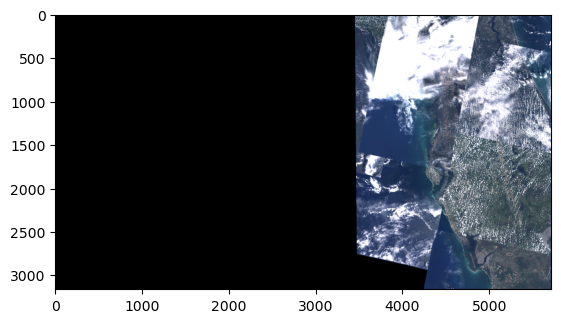

In [152]:
window = from_bounds(min_x, min_y, max_x, max_y, t)
window_transform = rasterio.windows.transform(window, t)
transformer = rasterio.transform.AffineTransformer(window_transform)

tl_y_px, tl_x_px = transformer.rowcol(tl_x, tl_y)
tr_y_px, tr_x_px = transformer.rowcol(tr_x, tr_y)
bl_y_px, bl_x_px = transformer.rowcol(bl_x, bl_y)
br_y_px, br_x_px = transformer.rowcol(br_x, br_y)
points_dst = np.array([[0, 0], [im_w, 0], [0, im_h], [im_w, im_h]], dtype=np.float32)
points_src = np.array([[tl_x_px, tl_y_px], [tr_x_px, tr_y_px], [bl_x_px, bl_y_px], [br_x_px, br_y_px]], dtype=np.float32)

M = cv2.getPerspectiveTransform(points_src, points_dst)
warped = cv2.warpPerspective(im, M, (im_w, im_h))
plt.imshow(warped)

print(warped.shape)


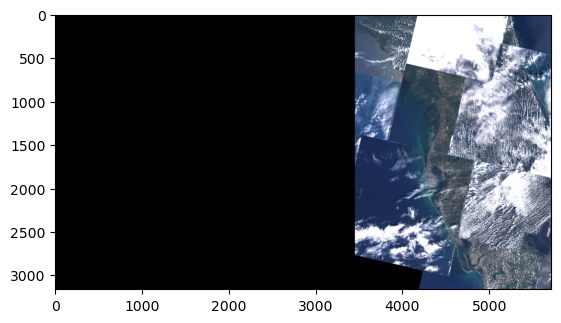

NameError: name 'warped' is not defined

In [13]:
plt.imshow(im)
plt.show()
resized = cv2.resize(warped, (4608, 2592))
plt.imshow(resized)

In [14]:
h, w = data.shape[:2]


In [15]:
min_y_px = min(tl_y_px, tr_y_px, bl_y_px, br_y_px)
max_y_px = max(tl_y_px, tr_y_px, bl_y_px, br_y_px)
min_x_px = min(tl_x_px, tr_x_px, bl_x_px, br_x_px)
max_x_px = max(tl_x_px, tr_x_px, bl_x_px, br_x_px)

In [16]:
min_y_px = max(0, min_y_px)

In [17]:
data = src.read((1,2,3), window=window, boundless = True)
data = np.moveaxis(data, 0, -1)

In [45]:
transformer = rasterio.transform.AffineTransformer(window_transform)
tl_y_px, tl_x_px = transformer.rowcol(tl_x, tl_y)
tr_y_px, tr_x_px = transformer.rowcol(tr_x, tr_y)
bl_y_px, bl_x_px = transformer.rowcol(bl_x, bl_y)
br_y_px, br_x_px = transformer.rowcol(br_x, br_y)
h,w = data.shape[:2]
points_dst = np.array([[0, 0], [w, 0], [0, h], [w, h]], dtype=np.float32)
points_src = np.array([[tl_x_px, tl_y_px], [tr_x_px, tr_y_px], [bl_x_px, bl_y_px], [br_x_px, br_y_px]], dtype=np.float32)

In [90]:
M = cv2.getPerspectiveTransform(points_src, points_dst)

In [92]:
warped = cv2.warpPerspective(data, M, (w, h))

In [93]:
resized = cv2.resize(warped, (4608, 2592))

16R
17R
2
6351 638 4578 1417


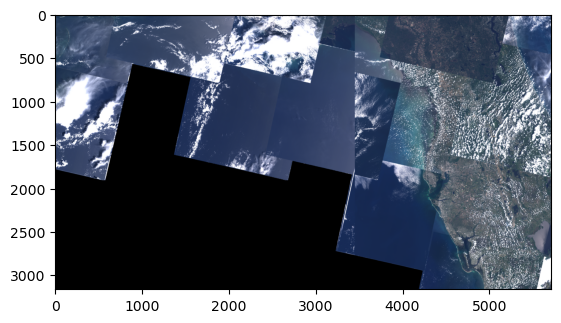

In [51]:
#with rasterio.open(os.path.join(base_path, ctr_region, os.listdir(os.path.join(base_path, ctr_region))[0])) as src:
regims = []
base_path = 'region_ims'
for region in current_regions:
    print(region)
    if region in skip_regions:
         continue
    if region is None:
        continue
    region_path = os.path.join(base_path, region)
    if os.path.exists(region_path):
        random_regim = np.random.choice(os.listdir(region_path))
        regim_path = os.path.join(region_path, random_regim)
        regims.append(regim_path)
regim_path = os.path.join(base_path, '16R', 'l8_16R_00000.tif')
regims.append(regim_path)
print(len(regims))
if len(regims) > 1:

    data, affine = rasterio.merge.merge(regims)
    data = np.moveaxis(data, 0, -1)
    transformer = rasterio.transform.AffineTransformer(affine)
    tl_lon, tl_lat = corner_lonlats['tl']
    tr_lon, tr_lat = corner_lonlats['tr']
    bl_lon, bl_lat = corner_lonlats['bl']
    br_lon, br_lat = corner_lonlats['br']

    p = pyproj.Proj('EPSG:3857')

    tl_x, tl_y = p(tl_lon, tl_lat)
    tr_x, tr_y = p(tr_lon, tr_lat)
    bl_x, bl_y = p(bl_lon, bl_lat)
    br_x, br_y = p(br_lon, br_lat)

    # max_lon = max([tl_lon, tr_lon, bl_lon, br_lon])
    # min_lon = min([tl_lon, tr_lon, bl_lon, br_lon])
    # max_lat = max([tl_lat, tr_lat, bl_lat, br_lat])
    # min_lat = min([tl_lat, tr_lat, bl_lat, br_lat])

    # tl_y_px, tl_x_px = transformer.rowcol(tl_lon, tl_lat)
    # tr_y_px, tr_x_px = transformer.rowcol(tr_lon, tr_lat)
    # bl_y_px, bl_x_px = transformer.rowcol(bl_lon, bl_lat)
    # br_y_px, br_x_px = transformer.rowcol(br_lon, br_lat)

    # max_lat_px, min_lon_px = transformer.rowcol(min_lon, min_lat)
    # min_lat_px, max_lon_px = transformer.rowcol(max_lon, max_lat)
    max_x = max([tl_x, tr_x, bl_x, br_x])
    max_y = max([tl_y, tr_y, bl_y, br_y])
    min_x = min([tl_x, tr_x, bl_x, br_x])
    min_y = min([tl_y, tr_y, bl_y, br_y])

    tl_y_px, tl_x_px = transformer.rowcol(tl_x, tl_y)
    tr_y_px, tr_x_px = transformer.rowcol(tr_x, tr_y)
    bl_y_px, bl_x_px = transformer.rowcol(bl_x, bl_y)
    br_y_px, br_x_px = transformer.rowcol(br_x, br_y)

    max_x_px = max([tl_x_px, tr_x_px, bl_x_px, br_x_px])
    min_x_px = min([tl_x_px, tr_x_px, bl_x_px, br_x_px])
    max_y_px = max([tl_y_px, tr_y_px, bl_y_px, br_y_px])
    min_y_px = min([tl_y_px, tr_y_px, bl_y_px, br_y_px])

    print(max_x_px, min_x_px, max_y_px, min_y_px)


    #window_transform = from_bounds(min_x, min_y, max_x, max_y, affine)
    #transformer = rasterio.transform.AffineTransformer(window_transform)
    #tl_x_px, tl_y_px = ~affine * (tl_x, tl_y)
    #tr_x_px, tr_y_px = ~affine * (tr_x, tr_y)
    #bl_x_px, bl_y_px = ~affine * (bl_x, bl_y)
    #br_x_px, br_y_px = ~affine * (br_x, br_y)
    #print(bl_y_px, tl_y_px, tl_x_px, tr_x_px)
    # tl_y_px, tl_x_px = transformer.rowcol(tl_x, tl_y)
    # tr_y_px, tr_x_px = transformer.rowcol(tr_x, tr_y)
    # bl_y_px, bl_x_px = transformer.rowcol(bl_x, bl_y)
    # br_y_px, br_x_px = transformer.rowcol(br_x, br_y)
    # max_lat_px = max([tl_y_px, tr_y_px, bl_y_px, br_y_px])
    # min_lat_px = min([tl_y_px, tr_y_px, bl_y_px, br_y_px])
    # min_lon_px = min([tl_x_px, tr_x_px, bl_x_px, br_x_px])
    # max_lon_px = max([tl_x_px, tr_x_px, bl_x_px, br_x_px])
    im = data[min_y_px:max_y_px, min_x_px:max_x_px]
    window_transform = from_bounds(min_x, min_y, max_x, max_y, affine)
    #im = data[min_lat_px:max_lat_px, min_lon_px:max_lon_px]
    plt.imshow(im)

    # print(max_lat_px, min_lat_px, min_lon_px, max_lon_px)
    
    # points_dst = np.array([[min_lon_px, min_lat_px], [max_lon_px, min_lat_px], [max_lon_px, max_lat_px], [min_lon_px, max_lat_px]]).astype(np.float32)
    # points_src = np.array([[tl_x_px, tl_y_px], [tr_x_px, tr_y_px], [br_x_px, br_y_px], [bl_x_px, bl_y_px]]).astype(np.float32)

    # print(points_dst)
    # print(points_src)
    # M = cv2.getPerspectiveTransform(points_dst, points_src)
    # data = np.moveaxis(data, 0, -1)
    # warped = cv2.warpPerspective(data, M, (data.shape[1], data.shape[0]))
    
    # #plt.imshow(warped)


    # cropped = warped[min_lat_px:max_lat_px, min_lon_px:max_lon_px]
    # plt.imshow(cropped)
    # print(cropped.shape)
    #data = data_old[max_lat_px:min_lat_px, min_lon_px:max_lon_px]
    #plt.imshow(data_old)

    #transform, width, height = calculate_default_transform(src.crs, crs, src.width, src.height, *src.bounds)




    # print(data.shape)
    # tl_x, tl_y = transformer.xy(0, 0)
    # br_x, br_y = transformer.xy(data.shape[1], data.shape[2])
    # transform, width, height = calculate_default_transform('EPSG:4326', crs, data.shape[2], data.shape[1], tl_x, br_y, br_x, tl_y)
    # out = np.zeros((height, width, 3), dtype='uint8')
    # for i, band in enumerate(data, 1):
    #     dest = np.zeros((height, width), dtype=band.dtype)
    #     print(band.shape)
    #     reproject(
    #         band, dest,
    #         src_transform=affine,
    #         src_crs='EPSG:4326',
    #         dst_transform=transform,
    #         dst_crs=crs,
    #         resampling=0)

    #     if i >3:
    #         break
    #     out[:, :, i-1] = dest
    # print(out.shape)
    # p = pyproj.Proj(crs)
    # tl_lon, tl_lat = corner_lonlats['tl']
    # tr_lon, tr_lat = corner_lonlats['tr']
    # bl_lon, bl_lat = corner_lonlats['bl']
    # br_lon, br_lat = corner_lonlats['br']

    # tl_x, tl_y = p(tl_lon, tl_lat)
    # tr_x, tr_y = p(tr_lon, tr_lat)
    # bl_x, bl_y = p(bl_lon, bl_lat)
    # br_x, br_y = p(br_lon, br_lat)
    
    # max_x = max([tl_x, tr_x, bl_x, br_x])
    # max_y = max([tl_y, tr_y, bl_y, br_y])
    # min_x = min([tl_x, tr_x, bl_x, br_x])
    # min_y = min([tl_y, tr_y, bl_y, br_y])
    # data = out
    #data = np.moveaxis(data, 0, -1)
    # max_lon = max([tl_lon, tr_lon, bl_lon, br_lon])
    # min_lon = min([tl_lon, tr_lon, bl_lon, br_lon])
    # max_lat = max([tl_lat, tr_lat, bl_lat, br_lat])
    # min_lat = min([tl_lat, tr_lat, bl_lat, br_lat])
    #plt.imshow(data)
elif len(regims) == 1:
    with rasterio.open(regims[0]) as src:
        #transform, width, height = calculate_default_transform(src.crs, src.width, src.height, *src.bounds)
        tl_lon, tl_lat = corner_lonlats['tl']
        tr_lon, tr_lat = corner_lonlats['tr']
        bl_lon, bl_lat = corner_lonlats['bl']
        br_lon, br_lat = corner_lonlats['br']
        max_lon = max([tl_lon, tr_lon, bl_lon, br_lon])
        min_lon = min([tl_lon, tr_lon, bl_lon, br_lon])
        max_lat = max([tl_lat, tr_lat, bl_lat, br_lat])
        min_lat = min([tl_lat, tr_lat, bl_lat, br_lat])
        # data = src.read((1,2,3))
        # plt.imshow(np.moveaxis(data, 0, -1))
        
        print(src.bounds)
        print(min_lon, min_lat, max_lon, max_lat)

        window = from_bounds(min_lon, min_lat, max_lon, max_lat, src.transform)
        window_transform = rasterio.windows.transform(window, src.transform)
        data = src.read((1,2,3), window=window, boundless = True)
        data = np.moveaxis(data, 0, -1)
        # plt.imshow(np.moveaxis(data, 0, -1))



#         transform, width, height = calculate_default_transform(src.crs, crs, src.width, src.height, *src.bounds)
#         # kwargs = src.meta.copy()
#         # kwargs.update({
#         #     'crs': crs,
#         #     'transform': transform,
#         #     'width': width,
#         #     'height': height
#         # })
#         data = src.read()
#         out = np.zeros((height, width, 3), dtype='uint8')
#         for i, band in enumerate(data, 1):
#             dest = np.zeros((height, width), dtype=band.dtype)
#             reproject(
#                 band, dest,
#                 src_transform=src.transform,
#                 src_crs=src.crs,
#                 dst_transform=transform,
#                 dst_crs=crs,
#                 resampling=0)
#             out[:, :, i-1] = dest

#         p = pyproj.Proj(crs)
#         tl_lon, tl_lat = corner_lonlats['tl']
#         tr_lon, tr_lat = corner_lonlats['tr']
#         bl_lon, bl_lat = corner_lonlats['bl']
#         br_lon, br_lat = corner_lonlats['br']

#         tl_x, tl_y = p(tl_lon, tl_lat)
#         tr_x, tr_y = p(tr_lon, tr_lat)
#         bl_x, bl_y = p(bl_lon, bl_lat)
#         br_x, br_y = p(br_lon, br_lat)

#         max_x = max([tl_x, tr_x, bl_x, br_x])
#         max_y = max([tl_y, tr_y, bl_y, br_y])
#         min_x = min([tl_x, tr_x, bl_x, br_x])
#         min_y = min([tl_y, tr_y, bl_y, br_y])

#         max_lon = max([tl_lon, tr_lon, bl_lon, br_lon])
#         min_lon = min([tl_lon, tr_lon, bl_lon, br_lon])
#         max_lat = max([tl_lat, tr_lat, bl_lat, br_lat])
#         min_lat = min([tl_lat, tr_lat, bl_lat, br_lat])
        
#         window = from_bounds(min_x, min_y, max_x, max_y, transform)
#         window_transform = rasterio.windows.transform(window, transform)
#         data = src.read((1,2,3), window=window, boundless = True)
#         data = np.moveaxis(data, 0, -1)
#         # print(data.shape)
#         plt.imshow(data)
#         plt.show()
# plt.imshow(data)
# plt.show()


0 0 6217 0 6094 3029 122 3029
[[          0           0]
 [       6217           0]
 [       6217        3030]
 [          0        3030]]
[[          0           0]
 [       6217           0]
 [       6094        3029]
 [        122        3029]]


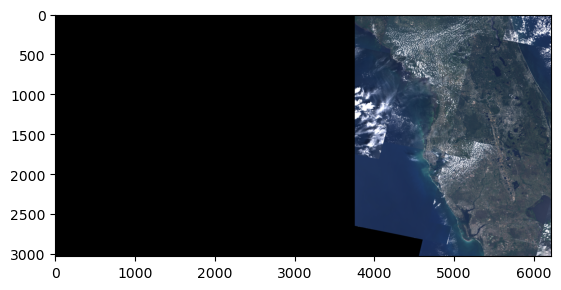

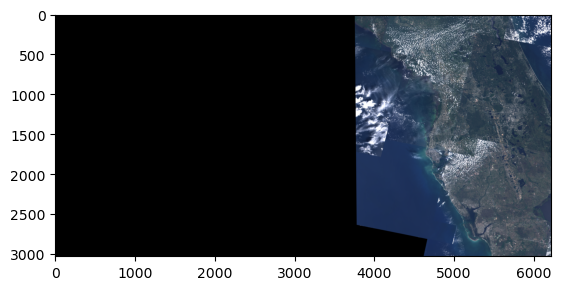

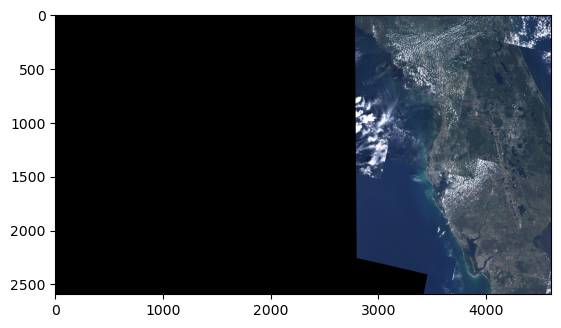

In [38]:
## 2nd case
transformer = rasterio.transform.AffineTransformer(window_transform)

p = pyproj.Proj('EPSG:3857')
tl_x, tl_y = p(tl_lon, tl_lat)
tr_x, tr_y = p(tr_lon, tr_lat)
bl_x, bl_y = p(bl_lon, bl_lat)
br_x, br_y = p(br_lon, br_lat)

tl_y_px, tl_x_px = transformer.rowcol(tl_x, tl_y)
tr_y_px, tr_x_px = transformer.rowcol(tr_x, tr_y)
bl_y_px, bl_x_px = transformer.rowcol(bl_x, bl_y)
br_y_px, br_x_px = transformer.rowcol(br_x, br_y)

tl_y_px, tl_x_px = transformer.rowcol(tl_lon, tl_lat)
tr_y_px, tr_x_px = transformer.rowcol(tr_lon, tr_lat)
bl_y_px, bl_x_px = transformer.rowcol(bl_lon, bl_lat)
br_y_px, br_x_px = transformer.rowcol(br_lon, br_lat)

dst_width = 4608
dst_height = 2592

h, w = data.shape[:2]

points_dst = np.array([[0, 0], [w, 0], [w, h], [0, h]]).astype(np.float32)
print(tl_x_px, tl_y_px, tr_x_px, tr_y_px, br_x_px, br_y_px, bl_x_px, bl_y_px)
points_src = np.array([[tl_x_px, tl_y_px], [tr_x_px, tr_y_px], [br_x_px, br_y_px], [bl_x_px, bl_y_px]]).astype(np.float32)
print(points_dst)
print(points_src)
M = cv2.getPerspectiveTransform(points_src, points_dst)
plt.imshow(data)
plt.show()
warped = cv2.warpPerspective(data, M, (w, h))
resized = cv2.resize(warped, (dst_width, dst_height))
plt.imshow(warped)
plt.show()

plt.imshow(resized)
plt.show()

In [25]:
 ## first case
transformer = rasterio.transform.AffineTransformer(transform)
print(transform)
tl_y_px, tl_x_px = transformer.rowcol(tl_x, tl_y)
tr_y_px, tr_x_px = transformer.rowcol(tr_x, tr_y)
bl_y_px, bl_x_px = transformer.rowcol(bl_x, bl_y)
br_y_px, br_x_px = transformer.rowcol(br_x, br_y)
# minlat_y, minlon_x = transformer.rowcol(min_lon, min_lat)
# maxlat_y, maxlon_x = transformer.rowcol(max_lon, max_lat)
min_y_px, min_x_px = transformer.rowcol(min_x, min_y)
max_y_px, max_x_px = transformer.rowcol(max_x, max_y)
print(min_y_px, min_x_px, max_y_px, max_x_px)
print(tl_x_px, tl_y_px, tr_x_px, tr_y_px, bl_x_px, bl_y_px, br_x_px, br_y_px)

plt.imshow(data[max_y_px:min_y_px, min_x_px:max_x_px])
plt.show()

data_old = data
data = data[max_y_px:min_y_px, min_x_px:max_x_px]

dst_width = 4608
dst_height = 2592
h, w = data.shape[:2]
points_dst = np.array([[min_x_px, max_y_px], [max_x_px, max_y_px], [max_x_px, min_y_px], [min_x_px, min_y_px]]).astype(np.float32)
points_src = np.array([[tl_x_px, tl_y_px], [tr_x_px, tr_y_px], [br_x_px, br_y_px], [bl_x_px, bl_y_px]]).astype(np.float32)

M = cv2.getPerspectiveTransform(points_src, points_dst)
warped = cv2.warpPerspective(data, M, (w, h))
plt.imshow(warped)
#cropped = warped[maxlat_y:minlat_y, minlon_x:maxlon_x]
resized = cv2.resize(warped, (dst_width, dst_height))
plt.imshow(resized)
bgr = cv2.cvtColor(resized, cv2.COLOR_RGB2BGR)


ValueError: Not an affine transform

In [9]:
import torch
for region in ['17R']:
    model_path = 'models/' + region + '.pt'
    model = YOLO(model_path)
    conf_threshold = float(np.load('best_confs/' + region + '_best_conf.npy'))
    best_classes = np.load('best_classes/' + region + '_best_classes.npy')
    results = model.predict(bgr, conf=conf_threshold, classes=best_classes, imgsz=(2592,4608))
    
    result = results[0]
    if len(result.boxes) > 0:
        classes = result.boxes.cls
        confs = result.boxes.conf
        xcs = result.boxes.xywh[:,0]
        ycs = result.boxes.xywh[:,1]
        im_dets = torch.stack([classes, xcs, ycs, confs], dim=1)


0: 2592x4608 1 46, 1 49, 1 51, 1 53, 1 54, 3 61s, 1 73, 1 85, 1 92, 1 101, 1 117, 1 138, 1 152, 1 162, 1 175, 1 186, 1 193, 1 194, 1 215, 1 218, 1 257, 1 266, 1 298, 1 304, 1 338, 1 339, 1 377, 1 383, 1 387, 1 389, 1 394, 1 414, 1 435, 1 447, 1 463, 64.5ms
Speed: 89.0ms preprocess, 64.5ms inference, 2.0ms postprocess per image at shape (1, 3, 2592, 4608)


In [19]:
import csv
print(im_dets)
print(best_classes)
best_classes = np.load('best_classes/' + region + '_best_classes.npy')
landmark_csv_path = 'landmark_csvs/' + region + '_top_salient.csv'
cnt = 0
with open(landmark_csv_path, 'r') as f:
    csv_reader = csv.DictReader(f)
    dictlist = list(csv_reader)
    for i, row in enumerate(csv_reader):
        if i in best_classes:
            cnt+=1
print(cnt)
print(dictlist)


tensor([[8.5000e+01, 3.5116e+03, 1.5628e+03, 9.8096e-01],
        [4.4700e+02, 3.5297e+03, 1.5040e+03, 9.5221e-01],
        [3.0400e+02, 3.9733e+03, 2.3261e+03, 9.3585e-01],
        [3.8900e+02, 4.0978e+03, 6.4328e+02, 9.2686e-01],
        [4.1400e+02, 3.5081e+03, 1.5127e+03, 9.2608e-01],
        [5.4000e+01, 4.2915e+03, 1.8070e+03, 9.1660e-01],
        [3.7700e+02, 3.5967e+03, 1.5852e+03, 9.1226e-01],
        [3.3800e+02, 3.4872e+03, 1.5197e+03, 9.1105e-01],
        [3.8300e+02, 4.4956e+03, 2.0537e+03, 9.1090e-01],
        [3.8700e+02, 3.8302e+03, 2.1584e+03, 8.9700e-01],
        [2.5700e+02, 4.5231e+03, 2.1780e+03, 8.7636e-01],
        [4.3500e+02, 4.5344e+03, 2.0777e+03, 8.7472e-01],
        [4.6300e+02, 4.5136e+03, 2.0716e+03, 8.6829e-01],
        [2.6600e+02, 3.8291e+03, 2.0983e+03, 8.6529e-01],
        [6.1000e+01, 3.4907e+03, 1.5099e+03, 8.6487e-01],
        [3.3900e+02, 4.5594e+03, 2.1475e+03, 8.5195e-01],
        [1.7500e+02, 3.5767e+03, 1.6122e+03, 8.5077e-01],
        [3.940

In [35]:
#compare read time of loading images with rasterio
import time
start = time.time()
for i in range(100):
    regim_path = 'region_ims/17R/l8_17R_00' + str(i).zfill(3) + '.tif'
    regim_path2 = 'region_ims/16T/l8_16T_00' + str(i).zfill(3) + '.tif'
    with rasterio.open(regim_path) as src:
        window = rasterio.windows.Window(1208,-3386 ,4553,  2337)
        data = src.read(window=window, boundless=True)
    with rasterio.open(regim_path2) as src:
        window = rasterio.windows.Window(1208,-3386 ,4553,  2337)
        data = src.read(window=window, boundless=True)
print(time.time() - start)


3.511723756790161


In [37]:
from SatCam import SatCam, SatellitePose
start = time.time()
pose = [549496.7936069818, -6128343.990241624, 3287548.8567509046, -0.07876803246160267, 0.878472092968163, -0.4712561712468741, -0.04208625123151773, 0.46937312065726633, 0.8819963838144332, 0.9960041890069568, 0.08930652540881052, -0.0]
pose = SatellitePose(pose)
satcam = SatCam(pose, 66, 4608, 2592)
print(time.time() - start)

0.0019991397857666016


In [39]:
start = time.time()
def get_orbit(tf=None):
    """
    Get the orbit information in ECEF coordinates.

    Returns:
        orbit_ecef (numpy.ndarray): The orbit position and attitude in ECEF coordinates with direction vectors.
        orbit_eci (numpy.ndarray): The orbit position in ECI coordinates with direction vectors.
        tsamp (numpy.ndarray): The time samples for Earth rotation.
        orbit_eci_q (numpy.ndarray): The orbit position and attitude in ECI coordinates with quaternions.
    """
    if tf is not None:
        orbit_eci, tsamp, orbit_eci_q = get_eci_orbit(tf)
    else:   
        orbit_eci, tsamp, orbit_eci_q = get_eci_orbit()
    # get time samples for Earth rotation
    Rzs = get_Rz(tsamp)
    # Get ECI position vector
    r_eci = orbit_eci[:, :3, np.newaxis]
    # Convert ECI position vector to ECEF
    r_ecef = np.matmul(Rzs, r_eci)

    # Stack position and attitude and convert to meters
    orbit_ecef = np.concatenate([r_ecef[:,:,0]*1000, orbit_eci[:,3:]], axis=1)
    return orbit_ecef, orbit_eci, tsamp, orbit_eci_q
print(time.time() - start)

0.0005006790161132812


In [41]:
def get_eci_orbit(tf=None):
    """
    Get the ECI (Earth-Centered Inertial) orbit.

    Returns:
        orbit_eci (list): List of ECI coordinates.
        tsamp (float): Time sampling interval.
        orbit_eci_q (list): List of ECI coordinates with quaternions.
    """
    if tf is not None:
        orbit_eci, tsamp, orbit_eci_q = get_random_orbit(tf=tf)
    else:
        orbit_eci, tsamp, orbit_eci_q = get_random_orbit()
    return orbit_eci, tsamp, orbit_eci_q

In [42]:
from orbit_gen import get_random_orbit, get_Rz, get_nadir_attitude, get_nadir_attitude_vectors
orbit_ecef, orbit_eci, tsamp, orbit_eci_q = get_orbit(10800)

In [43]:
dir_vec, up_vec, right_vec = get_nadir_attitude_vectors(orbit_ecef)
dir_vec_eci, up_vec_eci, right_vec_eci = get_nadir_attitude_vectors(orbit_eci)

In [45]:
traj_positions = orbit_ecef[:,:3]
nadir_orbit_ecef = np.concatenate([traj_positions, dir_vec, up_vec, right_vec],axis=1)
nadir_orbit_eci = np.concatenate([traj_positions, dir_vec_eci, up_vec_eci, right_vec_eci], axis=1)
orbit_path = 'orbits/pose'
detection_path = 'orbits/detections'

In [48]:
from astropy.coordinates import EarthLocation
def get_ground_track(orbit_ecef):
    """
    Calculates the latitude, longitude, and altitude of a satellite given its ECEF coordinates.
    
    Parameters:
        orbit_ecef (numpy.ndarray): Array of ECEF coordinates of the satellite.
    
    Returns:
        tuple: A tuple containing the latitude, longitude, and altitude of the satellite.
    """
    # Get the latitude, longitude, and altitude of the satellite
    loc = EarthLocation.from_geocentric(orbit_ecef[:,0], orbit_ecef[:,1], orbit_ecef[:,2], unit='m')
    lat = loc.lat.deg
    lon = loc.lon.deg
    alt = loc.height.value
    return lat, lon, alt

lats, lons, alt = get_ground_track(nadir_orbit_ecef)

In [50]:
regions = ['10S', '10T', '11R', '12R', '16T', '17R', '17T', '18S', 
                '32S', '32T', '33S', '33T', '52S', '53S', '54S', '54T']
orbit_num = -1
savevid = False
showim = False
check_err = True
satcam = None
im_w = 4608
im_h = 2592
vid_w = 576
vid_h = 324
vidname = str(orbit_num).zfill(5) + 'demo.avi'

if savevid:
    video = None

all_detections = []
errs = []

In [54]:
pose = [549496.7936069818, -6128343.990241624, 3287548.8567509046, -0.07876803246160267, 0.878472092968163, -0.4712561712468741, -0.04208625123151773, 0.46937312065726633, 0.8819963838144332, 0.9960041890069568, 0.08930652540881052, -0.0]

if satcam is None:
            satpose = SatellitePose(pose)
            satcam = SatCam(satpose, 66, im_w, im_h, regions=regions)
else:
            satpose = SatellitePose(pose)
            satcam.update_pose(satpose) 

In [55]:
satcam.check_for_all_landmarks()

True

In [56]:
corner_lonlats = satcam.corner_lonlats

In [57]:
tl_lon, tl_lat = corner_lonlats['tl']
br_lon, br_lat = corner_lonlats['br']
tr_lon, tr_lat = corner_lonlats['tr']
bl_lon, bl_lat = corner_lonlats['bl']
tl_reg = satcam.get_region(tl_lon, tl_lat)
br_reg = satcam.get_region(br_lon, br_lat)
tr_reg = satcam.get_region(tr_lon, tr_lat)
bl_reg = satcam.get_region(bl_lon, bl_lat)
ctr_reg = satcam.get_region(lons[i], lats[i])
cur_regions = [tl_reg, tr_reg, br_reg, bl_reg, ctr_reg]

In [63]:
from ultralytics import YOLO
def get_detections(img, region, window_transform, cam):
    model_path = 'models/' + region + '.pt'
    model = YOLO(model_path)
    conf_threshold = float(np.load('best_confs/' + region + '_best_conf.npy'))
    best_classes = np.load('best_classes/' + region + '_best_classes.npy')
    if os.path.exists('bad_classes/' + region + '_bad_classes.npy'):
        bad_classes = np.load('bad_classes/' + region + '_bad_classes.npy')
    else:
        bad_classes = []
    results = model.predict(img, conf=conf_threshold, classes=best_classes, imgsz=(2592, 4608), verbose=False)
    result = results[0]
    im_region_dets = []
    if len(result.boxes) > 0:
        for detection in result.boxes:
            cls = int(detection.cls.item())
            if cls not in bad_classes:
                xc, yc, w, h, = detection.xywh[0]
                xc, yc, w, h = xc.item(), yc.item(), w.item(), h.item()
                det_lon, det_lat = cam.convert_xc_yc_to_lon_lat(xc, yc, window_transform)
                cls_lon, cls_lat = get_lon_lat_from_cls(cls, region)
                det_pixel_location = cam.lonlat_to_pixel_coords(det_lon, det_lat)
                cls_pixel_location = cam.lonlat_to_pixel_coords(cls_lon, cls_lat)
                im_region_dets.append([cls, det_pixel_location[0], det_pixel_location[1], detection.conf.item()])
        return im_region_dets
    else:
        return None

In [111]:
region = '17R'
for i in range(50):
    satim, window_transform = satcam.get_image(region)

In [116]:
region = '17R'
for i in range(50):
    satim, window_transform = get_image(region, satcam)

In [115]:
def get_image(region, cam):
    base_path = 'region_ims'
    if region in cam.regions:
        if cam.region_ims[region] is None:
            region_path = os.path.join(base_path, region)
            regim = cam.choose_region_im(region)
            regim_path = os.path.join(region_path, regim)
            with rasterio.open(regim_path) as src:
                t = src.transform
                data = src.read((1,2,3))
                data = np.moveaxis(data, 0, -1)
                cam.region_ims[region] = data, t
        else:
            data, t = cam.region_ims[region]
    else:
        return None, None
    
    corner_lonlats = cam.corner_lonlats
    tl_lon, tl_lat = corner_lonlats['tl']
    tr_lon, tr_lat = corner_lonlats['tr']
    bl_lon, bl_lat = corner_lonlats['bl']
    br_lon, br_lat = corner_lonlats['br']

    min_lon = min([tl_lon, tr_lon, bl_lon, br_lon])
    max_lon = max([tl_lon, tr_lon, bl_lon, br_lon])
    min_lat = min([tl_lat, tr_lat, bl_lat, br_lat])
    max_lat = max([tl_lat, tr_lat, bl_lat, br_lat])

    p = pyproj.Proj('EPSG:3857')
    min_x, min_y = p(min_lon, min_lat)
    max_x, max_y = p(max_lon, max_lat)

    satim, window_transform = get_windowed_image(data, min_x, min_y, max_x, max_y, t)
    return satim, window_transform

def get_windowed_image(data, min_x, min_y, max_x, max_y, t):
    
    window = from_bounds(min_x, min_y, max_x, max_y, t)
    window_transform = rasterio.windows.transform(window, t)

    min_x_px, min_y_px = ~t*(min_x, max_y)
    max_x_px, max_y_px = ~t*(max_x, min_y)
    
    min_x_px = int(min_x_px)
    min_y_px = int(min_y_px)
    max_x_px = int(max_x_px)
    max_y_px = int(max_y_px)
    
    im_h = int(max_y_px - min_y_px)
    im_w = int(max_x_px - min_x_px)

    image = np.zeros((height, width, data.shape[2]), dtype=data.dtype)
    data_h, data_w, _ = data.shape

    data_min_x_px = max(0, min_x_px)
    data_max_x_px = min(data_w, max_x_px)
    data_min_y_px = max(0, min_y_px)
    data_max_y_px = min(data_h, max_y_px)

    if min_x_px < 0:
        im_min_x_px = -min_x_px
    else:
        im_min_x_px = 0
    if min_y_px < 0:
        im_min_y_px = -min_y_px
    else:
        im_min_y_px = 0
    if max_x_px > data_w:
        im_max_x_px = int(im_w - (max_x_px - data_w))
    else:
        im_max_x_px = im_w
    if max_y_px > data_h:
        im_max_y_px = int(im_h - (max_y_px - data_h))
    else:
        im_max_y_px = im_h

    image[im_min_y_px:im_max_y_px, im_min_x_px:im_max_x_px] = data[data_min_y_px:data_max_y_px, data_min_x_px:data_max_x_px]

    return image, window_transform

    
    
    
        


-3454.5294960818646 1417.280057343134 2259.335133111963 4578.143416163057
3161 5713


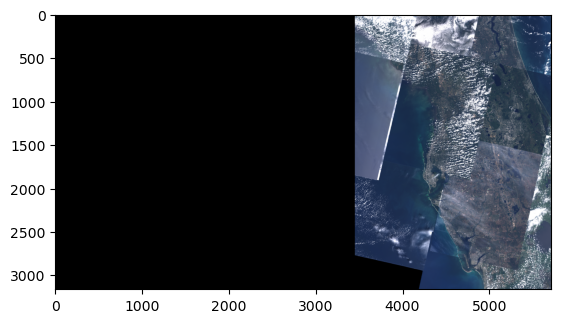

In [108]:
with rasterio.open(regim_path) as src:
    t = src.transform
    data = src.read((1,2,3))
    data = np.moveaxis(data, 0, -1)
cam = satcam
corner_lonlats = cam.corner_lonlats
tl_lon, tl_lat = corner_lonlats['tl']
tr_lon, tr_lat = corner_lonlats['tr']
bl_lon, bl_lat = corner_lonlats['bl']
br_lon, br_lat = corner_lonlats['br']

min_lon = min([tl_lon, tr_lon, bl_lon, br_lon])
max_lon = max([tl_lon, tr_lon, bl_lon, br_lon])
min_lat = min([tl_lat, tr_lat, bl_lat, br_lat])
max_lat = max([tl_lat, tr_lat, bl_lat, br_lat])

p = pyproj.Proj('EPSG:3857')
min_x, min_y = p(min_lon, min_lat)
max_x, max_y = p(max_lon, max_lat)


window = from_bounds(min_x, min_y, max_x, max_y, t)
window_transform = rasterio.windows.transform(window, t)

min_x_px, min_y_px = ~t*(min_x, max_y)
max_x_px, max_y_px = ~t*(max_x, min_y)
print(min_x_px, min_y_px, max_x_px, max_y_px)
min_x_px = int(min_x_px)
min_y_px = int(min_y_px)
max_x_px = int(max_x_px)
max_y_px = int(max_y_px)


height = int(max_y_px - min_y_px)
width = int(max_x_px - min_x_px)
im_h = height
im_w = width
print(height, width)
# height = int(max_y - min_y)
# width = int(max_x - min_x)

# Create an empty image with zeros
image = np.zeros((height, width, data.shape[2]), dtype=data.dtype)
data_h, data_w, _ = data.shape

data_min_x_px = max(0, min_x_px)
data_max_x_px = min(data_w, max_x_px)
data_min_y_px = max(0, min_y_px)
data_max_y_px = min(data_h, max_y_px)

if min_x_px < 0:
    im_min_x_px = -min_x_px
else:
    im_min_x_px = 0
if min_y_px < 0:
    im_min_y_px = -min_y_px
else:
    im_min_y_px = 0
if max_x_px > data_w:
    im_max_x_px = int(im_w - (max_x_px - data_w))
else:
    im_max_x_px = im_w
if max_y_px > data_h:
    im_max_y_px = int(im_h - (max_y_px - data_h))
else:
    im_max_y_px = im_h

image[im_min_y_px:im_max_y_px, im_min_x_px:im_max_x_px] = data[data_min_y_px:data_max_y_px, data_min_x_px:data_max_x_px]
plt.imshow(image)



In [91]:
cam = satcam
corner_lonlats = cam.corner_lonlats
tl_lon, tl_lat = corner_lonlats['tl']
tr_lon, tr_lat = corner_lonlats['tr']
bl_lon, bl_lat = corner_lonlats['bl']
br_lon, br_lat = corner_lonlats['br']

min_lon = min([tl_lon, tr_lon, bl_lon, br_lon])
max_lon = max([tl_lon, tr_lon, bl_lon, br_lon])
min_lat = min([tl_lat, tr_lat, bl_lat, br_lat])
max_lat = max([tl_lat, tr_lat, bl_lat, br_lat])

p = pyproj.Proj('EPSG:3857')
min_x, min_y = p(min_lon, min_lat)
max_x, max_y = p(max_lon, max_lat)
print(min_x, min_y, max_x, max_y)

-9914670.597683407 3020851.4338512695 -8982099.440317962 3536742.1999271573


In [95]:
min_x_px, min_y_px = ~window_transform*(min_x, min_y)
max_x_px, max_y_px = ~window_transform*(max_x, max_y)
print(min_x_px, min_y_px, max_x_px, max_y_px)

0.0 3160.8633588199264 5713.864629193828 3.637978807091713e-12


In [ ]:
region = '17R'
for i in range(150):
    satim, window_transform = get_image(region)

In [ ]:
region = '17R'
def get_lon_lat_from_cls(cls, region):
    landmark_csv_path = 'landmark_csvs/' + region + '_top_salient.csv'
    with open(landmark_csv_path, 'r') as f:
        csv_reader = csv.DictReader(f)
        dictlist = list(csv_reader)
    lon_lat_dict = dictlist[cls]
    lon = lon_lat_dict['Centroid Longitude']
    lat = lon_lat_dict['Centroid Latitude']
    return lon, lat

In [ ]:
satim = cv2.cvtColor(satim, cv2.COLOR_RGB2BGR)


In [75]:
dets = get_detections(satim, region, window_transform, satcam)

In [76]:
print(dets)

[]


In [52]:
region = '17R'
satim = im
img = satim
model_path = 'models/' + region + '.pt'
model = YOLO(model_path)
conf_threshold = float(np.load('best_confs/' + region + '_best_conf.npy'))
best_classes = np.load('best_classes/' + region + '_best_classes.npy')
if os.path.exists('bad_classes/' + region + '_bad_classes.npy'):
    bad_classes = np.load('bad_classes/' + region + '_bad_classes.npy')
else:
    bad_classes = []
results = model.predict(img, conf=conf_threshold, classes=best_classes, imgsz=(2592, 4608), verbose=False)
result = results[0]
im_region_dets = []

In [58]:
len(result)
model = None

In [80]:
if len(result.boxes) > 0:
        for detection in result.boxes:
            cls = int(detection.cls.item())
            if cls not in bad_classes:
                xc, yc, w, h, = detection.xywh[0]
                xc, yc, w, h = xc.item(), yc.item(), w.item(), h.item()
                det_lon, det_lat = cam.convert_xc_yc_to_lon_lat(xc, yc, window_transform)
                cls_lon, cls_lat = get_lon_lat_from_cls(cls, region)
                det_pixel_location = cam.lonlat_to_pixel_coords(det_lon, det_lat)
                cls_pixel_location = cam.lonlat_to_pixel_coords(cls_lon, cls_lat)
                im_region_dets.append([cls, det_pixel_location[0], det_pixel_location[1], detection.conf.item()])

In [1]:
from ultralytics import YOLO
def get_detections(img, region, window_transform, cam):
    model_path = 'models/' + region + '.pt'
    model = YOLO(model_path)
    conf_threshold = float(np.load('best_confs/' + region + '_best_conf.npy'))
    best_classes = np.load('best_classes/' + region + '_best_classes.npy')
    if os.path.exists('bad_classes/' + region + '_bad_classes.npy'):
        bad_classes = np.load('bad_classes/' + region + '_bad_classes.npy')
    else:
        bad_classes = []
    results = model.predict(img, conf=conf_threshold, classes=best_classes, imgsz=(2592, 4608), verbose=False)
    result = results[0]
    im_region_dets = []
    if len(result.boxes) > 0:
        for detection in result.boxes:
            cls = int(detection.cls.item())
            if cls not in bad_classes:
                xc, yc, w, h, = detection.xywh[0]
                xc, yc, w, h = xc.item(), yc.item(), w.item(), h.item()
                det_lon, det_lat = cam.convert_xc_yc_to_lon_lat(xc, yc, window_transform)
                cls_lon, cls_lat = get_lon_lat_from_cls(cls, region)
                det_pixel_location = cam.lonlat_to_pixel_coords(det_lon, det_lat)
                cls_pixel_location = cam.lonlat_to_pixel_coords(cls_lon, cls_lat)
                im_region_dets.append([cls, det_pixel_location[0], det_pixel_location[1], detection.conf.item()])
        return im_region_dets
    else:
        return None

In [77]:
cam = satcam
im_region_dets = []
outlier_list = []
import csv
window = from_bounds(min_x, min_y, max_x, max_y, affine)
window_transform = rasterio.windows.transform(window, affine)


if len(result.boxes) > 0:
    for detection in result.boxes:
        cls = int(detection.cls.item())
        if cls not in bad_classes:
            xc, yc, w, h, = detection.xywh[0]
            xc, yc, w, h = xc.item(), yc.item(), w.item(), h.item()
            det_lon, det_lat = cam.convert_xc_yc_to_lon_lat(xc, yc, window_transform)
            cls_lon, cls_lat = get_lon_lat_from_cls(cls, region)
            det_pixel_location = cam.lonlat_to_pixel_coords(det_lon, det_lat)
            print(det_pixel_location)
            cls_pixel_location = cam.lonlat_to_pixel_coords(cls_lon, cls_lat)
            print(cls_pixel_location)
            if det_pixel_location[0] < 0 or det_pixel_location[0] > 4608 or det_pixel_location[1] < 0 or det_pixel_location[1] > 2592:
                continue
            
            im_region_dets.append([cls, cls_pixel_location[0], cls_pixel_location[1], det_pixel_location[0], det_pixel_location[1], detection.conf.item()])

[     4555.8        2101]
[     4552.8      2100.8]
[       4559      2087.2]
[     4557.1      2084.7]
[     4583.6      2203.5]
[       4582      2205.1]
[     4607.4      2107.2]
[     4621.4      2102.7]
[       4619      2168.6]
[     4613.4      2166.5]
[     4625.4      2103.4]
[     4634.9      2096.8]
[     4579.9      2148.8]
[     4581.1      2152.3]
[     4589.4      2102.9]
[     4607.6      2098.1]
[     4592.1        2067]
[     4597.9      2066.8]


In [64]:
def get_lon_lat_from_cls(cls, region):
    landmark_csv_path = 'landmark_csvs/' + region + '_top_salient.csv'
    with open(landmark_csv_path, 'r') as f:
        csv_reader = csv.DictReader(f)
        dictlist = list(csv_reader)
    lon_lat_dict = dictlist[cls]
    lon = lon_lat_dict['Centroid Longitude']
    lat = lon_lat_dict['Centroid Latitude']
    return lon, lat

In [78]:
im_region_dets
new_im = img.copy()
new_im = cv2.resize(new_im, (4608, 2592))

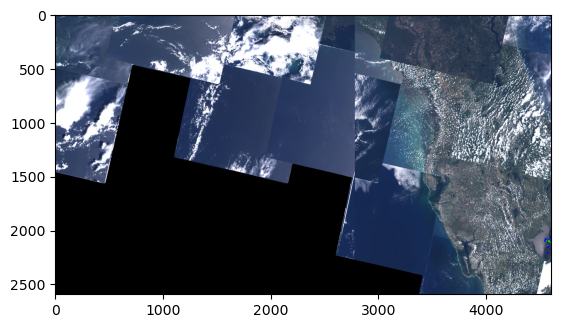

In [79]:
for det in im_region_dets:
    cls, cls_x, cls_y, x, y, conf = det
    new_im = cv2.circle(new_im, (int(x), int(y)), 10, (0, 255, 0), -1)
    new_im = cv2.circle(new_im, (int(cls_x), int(cls_y)), 10, (0, 0, 255), -1)
    new_im = cv2.line(new_im, (int(x), int(y)), (int(cls_x), int(cls_y)), (255, 0, 0), 1)
plt.imshow(new_im)

